# STUDY HOURS ESTIMATOR

In [3]:
import numpy as np
import pandas as pd

# visuals
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# for features
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

# model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# saving/loading
import pickle

df = pd.read_csv('study-dataset/StudentPerformanceFactors.csv')
df.head().T

,0,1,2,3,4
Hours_Studied,23,19,24,29,19
Attendance,84,64,98,89,92
Parental_Involvement,Low,Low,Medium,Low,Medium
Access_to_Resources,High,Medium,Medium,Medium,Medium
Extracurricular_Activities,No,No,Yes,Yes,Yes
Sleep_Hours,7,8,7,8,6
Previous_Scores,73,59,91,98,65
Motivation_Level,Low,Low,Medium,Medium,Medium
Internet_Access,Yes,Yes,Yes,Yes,Yes
Tutoring_Sessions,0,2,2,1,3


# Data Preparation

In [4]:
# column names to lowercase
df.columns = df.columns.str.lower()

cat_variables = df.select_dtypes('object').columns

# make values uniform
for column_name in cat_variables:
    df[column_name] = df[column_name].str.lower().str.replace(' ', '_')

In [5]:
ordinal_order = ['low', 'medium', 'high']
ordinal_data = ['parental_involvement', 'access_to_resources', 'family_income', 'teacher_quality', 'motivation_level']

# for cols in ordinal_data:
#     df[cols] = pd.Categorical(df[cols], categories=ordinal_order, ordered=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   hours_studied               6607 non-null   int64 
 1   attendance                  6607 non-null   int64 
 2   parental_involvement        6607 non-null   object
 3   access_to_resources         6607 non-null   object
 4   extracurricular_activities  6607 non-null   object
 5   sleep_hours                 6607 non-null   int64 
 6   previous_scores             6607 non-null   int64 
 7   motivation_level            6607 non-null   object
 8   internet_access             6607 non-null   object
 9   tutoring_sessions           6607 non-null   int64 
 10  family_income               6607 non-null   object
 11  teacher_quality             6529 non-null   object
 12  school_type                 6607 non-null   object
 13  peer_influence              6607 non-null   obje

### Missing Values

In [6]:
df.isnull().any()

hours_studied                 False
attendance                    False
parental_involvement          False
access_to_resources           False
extracurricular_activities    False
sleep_hours                   False
previous_scores               False
motivation_level              False
internet_access               False
tutoring_sessions             False
family_income                 False
teacher_quality                True
school_type                   False
peer_influence                False
physical_activity             False
learning_disabilities         False
parental_education_level       True
distance_from_home             True
gender                        False
exam_score                    False
dtype: bool

In [7]:
df.isnull().sum()

hours_studied                  0
attendance                     0
parental_involvement           0
access_to_resources            0
extracurricular_activities     0
sleep_hours                    0
previous_scores                0
motivation_level               0
internet_access                0
tutoring_sessions              0
family_income                  0
teacher_quality               78
school_type                    0
peer_influence                 0
physical_activity              0
learning_disabilities          0
parental_education_level      90
distance_from_home            67
gender                         0
exam_score                     0
dtype: int64

For dealing with the missing values, I first decided to replace them with "Do_not_have_this_feature". The columns with missing values are categorical. However, this was a little bit worse than simply dropping the rows. Thus, I will just drop the rows with missing values.

In [8]:
df.dropna(inplace=True)

In [9]:
y = df['hours_studied'].values

# split data 80 20 (splitting another 20 from 80 later)
df_full_train, df_test, y_full, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
print(len(df_full_train), len(y_full))

5102 5102


# EDA

The exploratory data analysis allowed me to determine the presence of outliers in the *exam_score* column with respect to *study_hours*. An adjustment using the *Interquartile Range(IQR)* was performed to allow regression models to capture the pattern better. Other than this, the rest of the features did not show promising patterns that could improve the model significantly. The relationship of some of the features was also looked into. However, there weren't any useful relationship between them that could enhance the performance of the model.

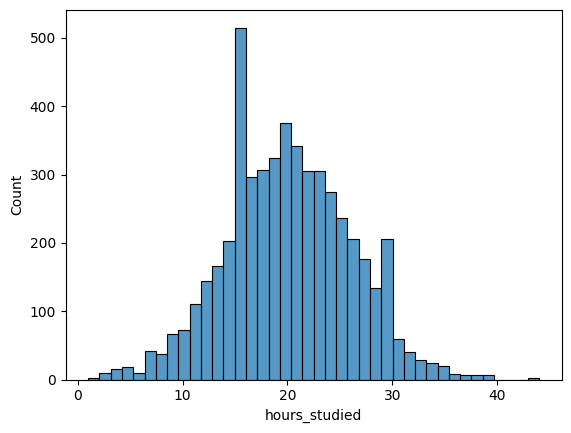

In [8]:
sns.histplot(df_full_train.hours_studied, bins=40)
plt.show()

This is a normal distribution. There is no need to perform transformation.

In [9]:
df_full_train.describe()

,hours_studied,attendance,sleep_hours,previous_scores,tutoring_sessions,physical_activity,exam_score
count,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000
mean,20.067817,80.086241,7.030380,74.977068,1.490396,2.973148,67.296354
std,6.001936,11.570806,1.459261,14.368019,1.224547,1.033579,3.980789
min,1.000000,60.000000,4.000000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.000000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.000000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.000000,87.000000,2.000000,4.000000,70.000000
max,44.000000,100.000000,10.000000,100.000000,8.000000,6.000000,101.000000


In [10]:
numerical_cols = df_full_train.select_dtypes('number').columns
df_full_train[numerical_cols].corr()

,hours_studied,attendance,sleep_hours,previous_scores,tutoring_sessions,physical_activity,exam_score
hours_studied,1.000000,0.003264,0.011225,0.023947,-0.022237,0.002601,0.441340
attendance,0.003264,1.000000,-0.016735,-0.015721,0.010684,-0.028034,0.575227
sleep_hours,0.011225,-0.016735,1.000000,-0.021463,-0.013605,-0.010507,-0.017209
previous_scores,0.023947,-0.015721,-0.021463,1.000000,-0.012074,-0.007051,0.170867
tutoring_sessions,-0.022237,0.010684,-0.013605,-0.012074,1.000000,0.018615,0.143834
physical_activity,0.002601,-0.028034,-0.010507,-0.007051,0.018615,1.000000,0.016610
exam_score,0.441340,0.575227,-0.017209,0.170867,0.143834,0.016610,1.000000


## Numerical Variables

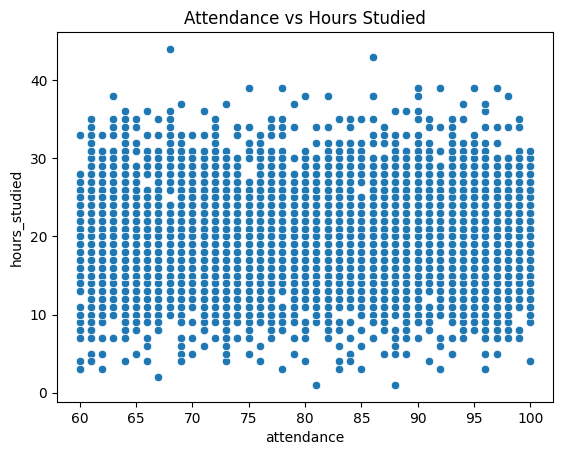

In [11]:
sns.scatterplot(x=df_full_train['attendance'], y=df_full_train['hours_studied'])
plt.title('Attendance vs Hours Studied');

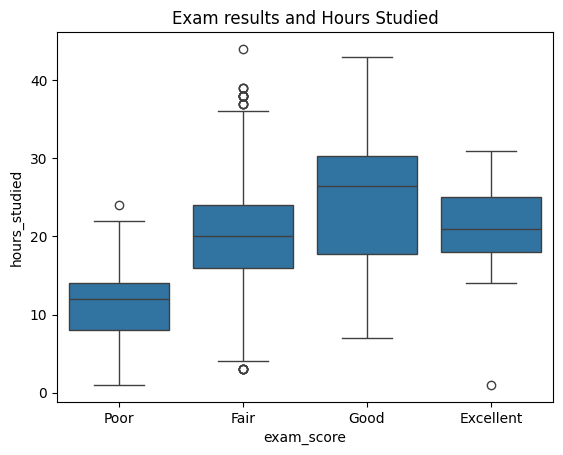

In [12]:
# i decided to categorize the exam scores in 4 categories
bins = [50, 60, 75, 90, 100]
labels = ['Poor', 'Fair', 'Good', 'Excellent']
df_exams_cat = pd.cut(df_full_train['exam_score'], bins=bins, labels=labels)
sns.boxplot(x=df_exams_cat, y=df_full_train['hours_studied'])
plt.title('Exam results and Hours Studied');

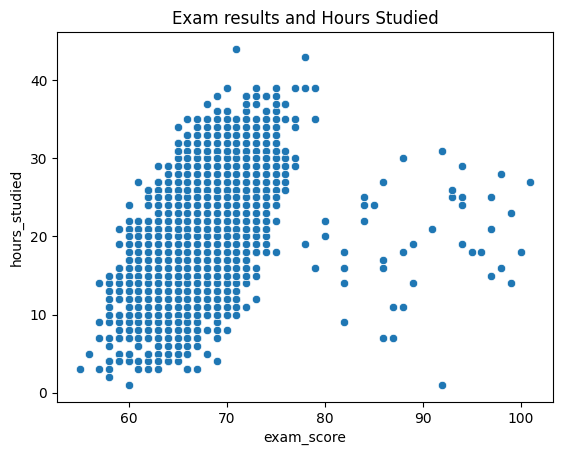

In [13]:
sns.scatterplot(x=df_full_train['exam_score'], y=df_full_train['hours_studied'])
plt.title('Exam results and Hours Studied');

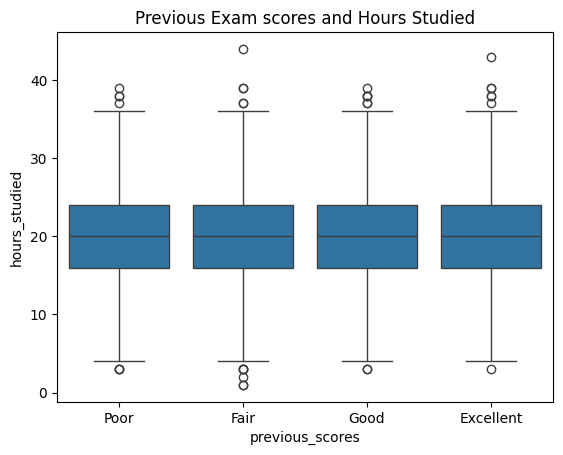

In [14]:
# i decided to categorize the exam scores in 4 categories
bins = [50, 60, 75, 90, 100]
labels = ['Poor', 'Fair', 'Good', 'Excellent']
df_exams_cat = pd.cut(df_full_train['previous_scores'], bins=bins, labels=labels)
sns.boxplot(x=df_exams_cat, y=df_full_train['hours_studied'])
plt.title('Previous Exam scores and Hours Studied');

It seems that previous exam scores did not affect the total hours studied.

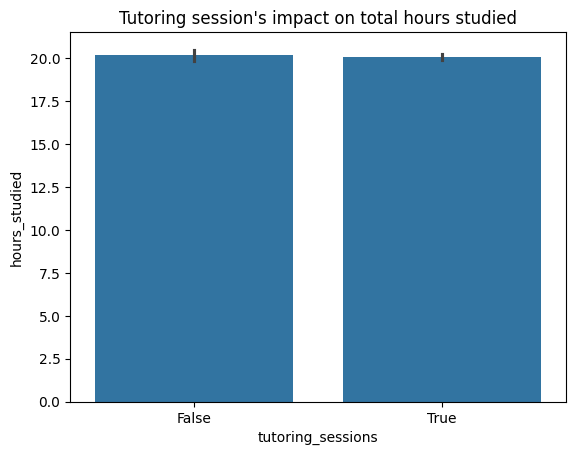

In [15]:
df_exams_cat = (df_full_train['tutoring_sessions'] != 0)
sns.barplot(x=df_exams_cat, y=df_full_train['hours_studied'])
plt.title('Tutoring session\'s impact on total hours studied');

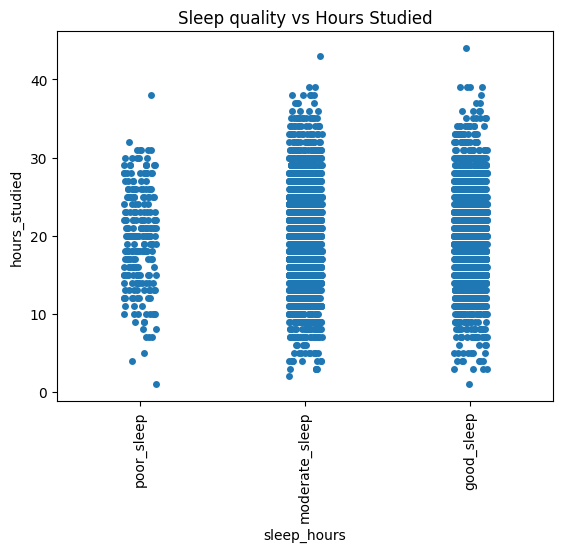

In [16]:
bins = [0, 4, 7, 10]
labels = ['poor_sleep', 'moderate_sleep', 'good_sleep']
df_exams_cat = pd.cut(df_full_train['sleep_hours'], bins=bins, labels=labels)
sns.stripplot(x=df_exams_cat, y=df_full_train['hours_studied'])
plt.title('Sleep quality vs Hours Studied')
plt.xticks(rotation=90);

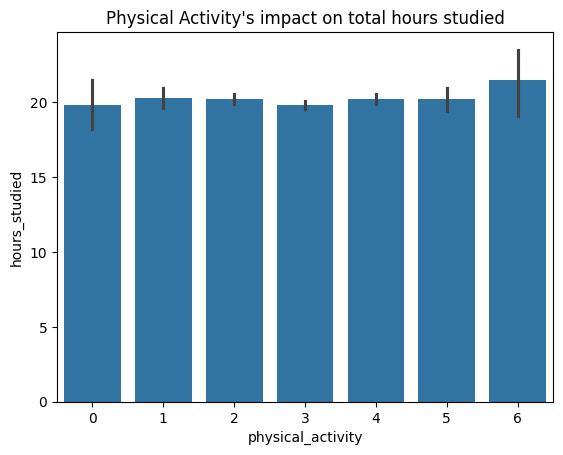

In [17]:
sns.barplot(x=df_full_train['physical_activity'], y=df_full_train['hours_studied'])
plt.title('Physical Activity\'s impact on total hours studied');

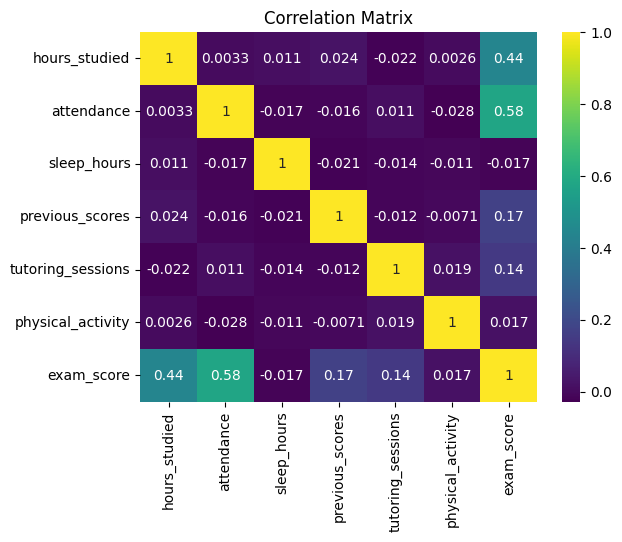

In [18]:
corr_matrix = df_full_train[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

*exam_score* shows moderate correlation with *hours_studied*. The rest have very low correlation.

### Outlier adjustments

In [19]:
# extract the outliers from exam_score(a moderately correlated feature to hours studied)
Q1 = df_full_train['exam_score'].quantile(0.25)
Q3 = df_full_train['exam_score'].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = (df_full_train['exam_score'] < (Q1 - 1.5 * IQR)) | (df_full_train['exam_score'] > (Q3 + 1.5 * IQR))
outliers = df_full_train[outlier_condition]
# handle outlier using median
median_score = df_full_train['exam_score'].median()
df_full_train.loc[outlier_condition, 'exam_score'] = median_score

In [20]:
# confirming that no errors were made
len(df_full_train), len(y_full)

(5102, 5102)

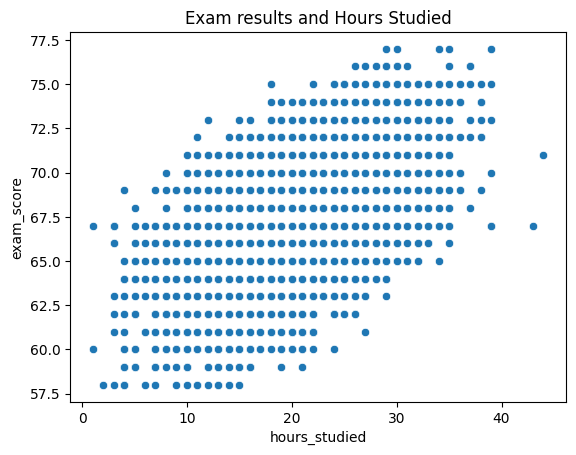

In [21]:
sns.scatterplot(y=df_full_train['exam_score'], x=df_full_train['hours_studied'])
plt.title('Exam results and Hours Studied');

## Categorical Variables

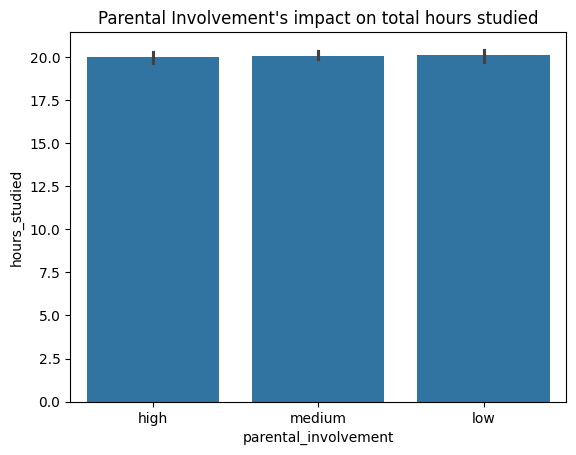

In [22]:
sns.barplot(x=df_full_train['parental_involvement'], y=df_full_train['hours_studied'])
plt.title('Parental Involvement\'s impact on total hours studied');

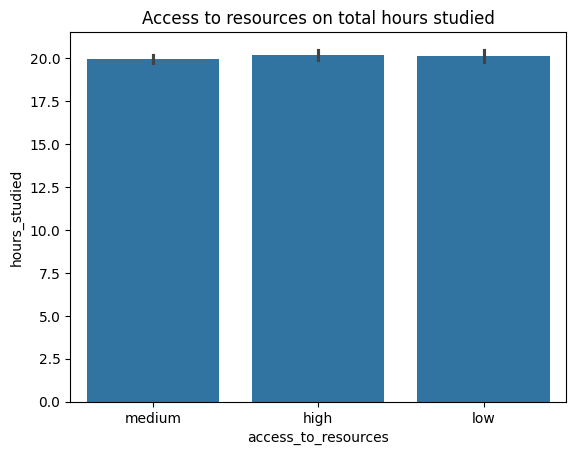

In [23]:
sns.barplot(x=df_full_train['access_to_resources'], y=df_full_train['hours_studied'])
plt.title('Access to resources on total hours studied');

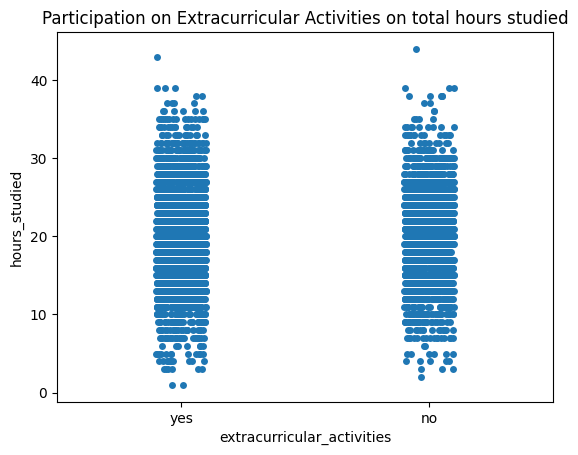

In [24]:
sns.stripplot(x=df_full_train['extracurricular_activities'], y=df_full_train['hours_studied'])
plt.title('Participation on Extracurricular Activities on total hours studied');

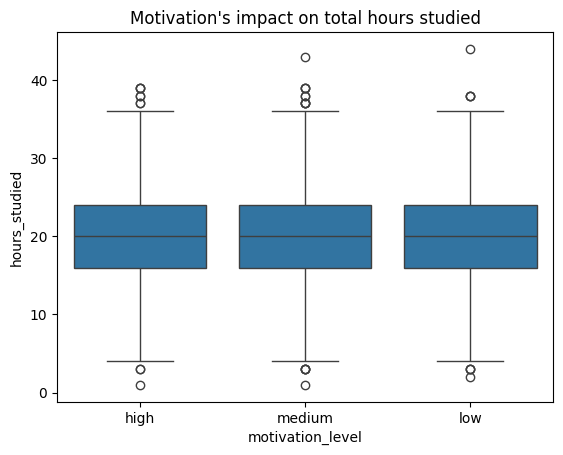

In [25]:
sns.boxplot(x=df_full_train['motivation_level'], y=df_full_train['hours_studied'])
plt.title('Motivation\'s impact on total hours studied');

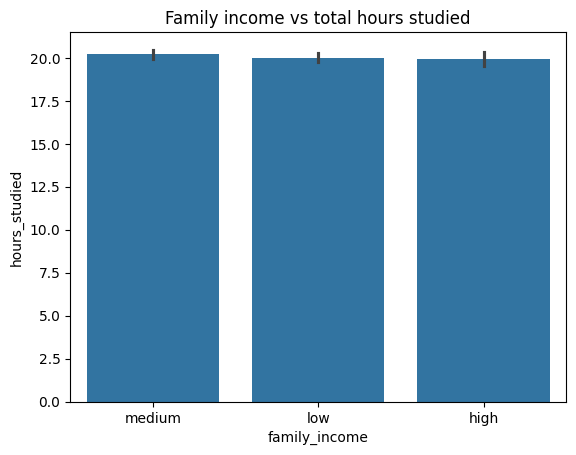

In [26]:
sns.barplot(x=df_full_train['family_income'], y=df_full_train['hours_studied'])
plt.title('Family income vs total hours studied');

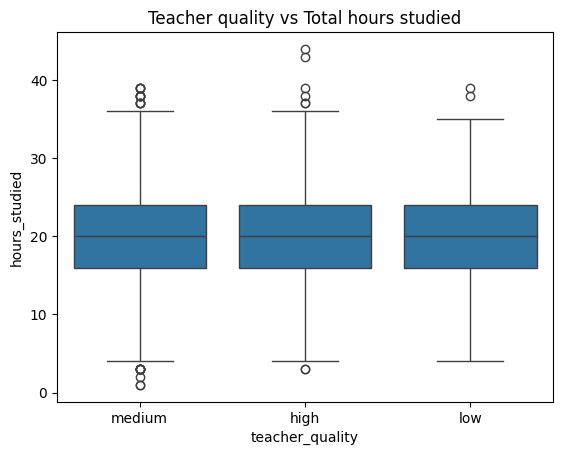

In [27]:
sns.boxplot(x=df_full_train['teacher_quality'], y=df_full_train['hours_studied'])
plt.title('Teacher quality vs Total hours studied');

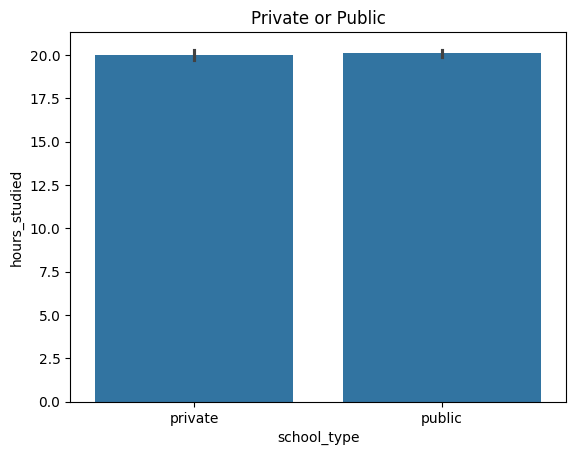

In [28]:
sns.barplot(x=df_full_train['school_type'], y=df_full_train['hours_studied'])
plt.title('Private or Public');

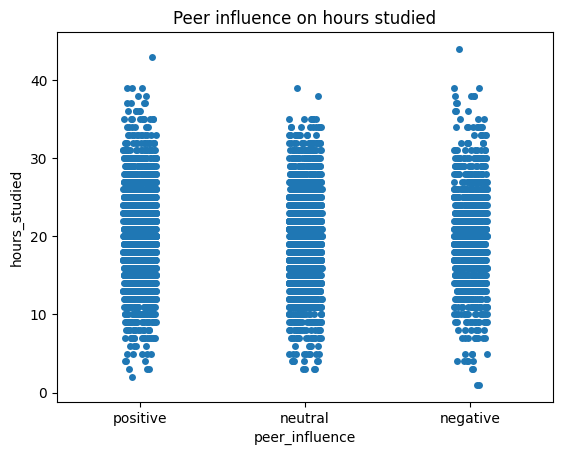

In [29]:
sns.stripplot(x=df_full_train['peer_influence'], y=df_full_train['hours_studied'])
plt.title('Peer influence on hours studied');

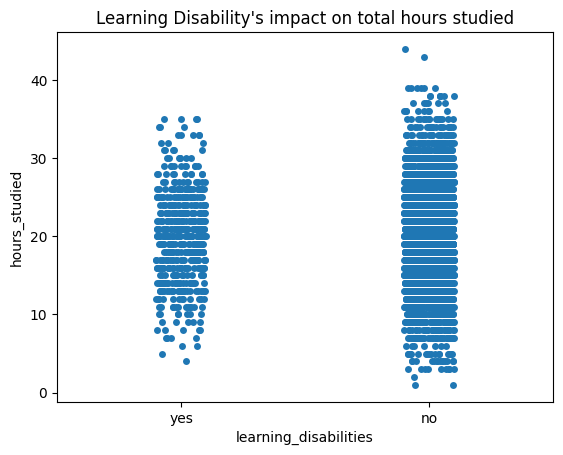

In [30]:
sns.stripplot(x=df_full_train['learning_disabilities'], y=df_full_train['hours_studied'])
plt.title('Learning Disability\'s impact on total hours studied');

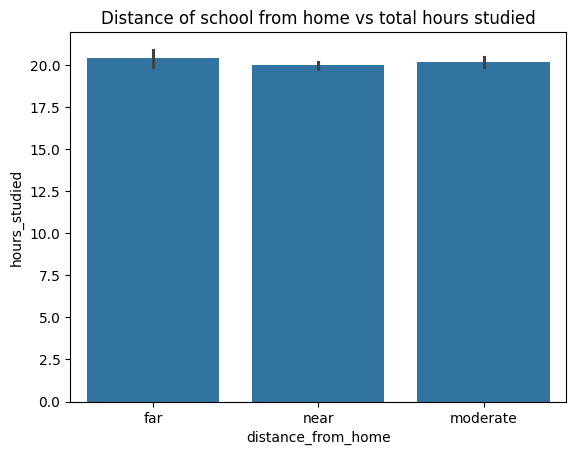

In [31]:
sns.barplot(x=df_full_train['distance_from_home'], y=df_full_train['hours_studied'])
plt.title('Distance of school from home vs total hours studied');

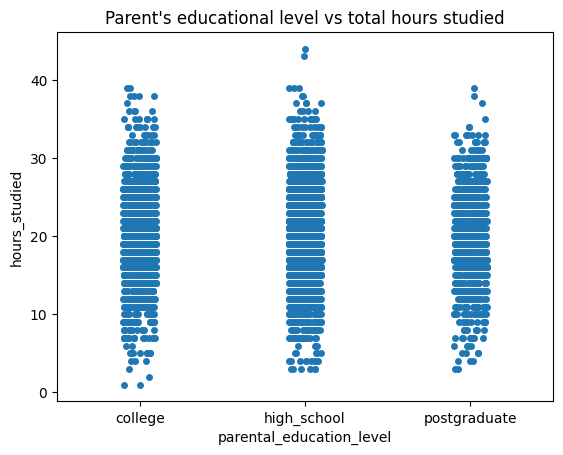

In [32]:
sns.stripplot(x=df_full_train['parental_education_level'], y=df_full_train['hours_studied'])
plt.title('Parent\'s educational level vs total hours studied');

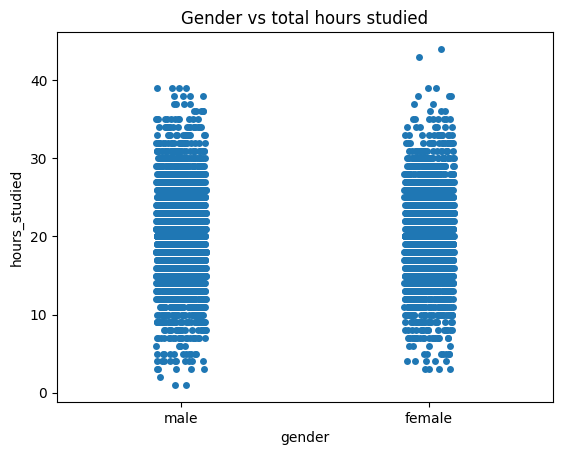

In [33]:
sns.stripplot(x=df_full_train['gender'], y=df_full_train['hours_studied'])
plt.title('Gender vs total hours studied');

There's barely any useful information from these features associated with the number of hours studied.

### Exploring more

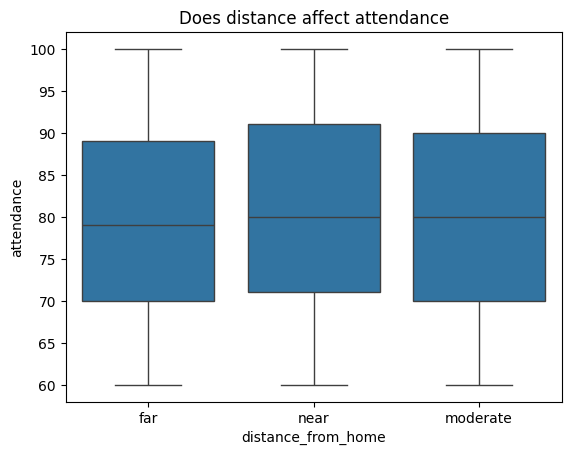

In [34]:
sns.boxplot(x=df_full_train['distance_from_home'], y=df_full_train['attendance'])
plt.title('Does distance affect attendance'); 

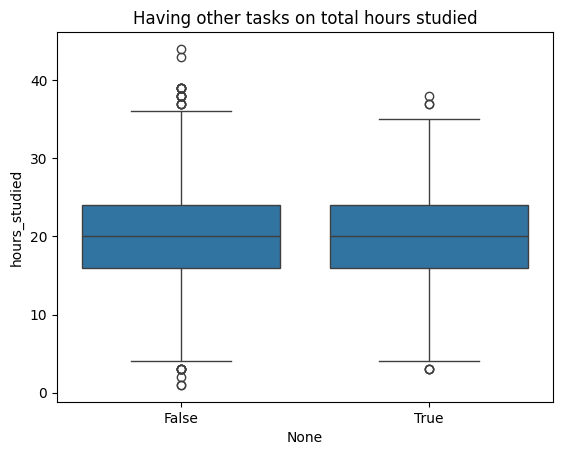

In [35]:
sns.boxplot(x=((df_full_train['physical_activity'] >= 4) & (df_full_train['extracurricular_activities'] == 'yes')), y=df_full_train['hours_studied'])
plt.title('Having other tasks on total hours studied'); 

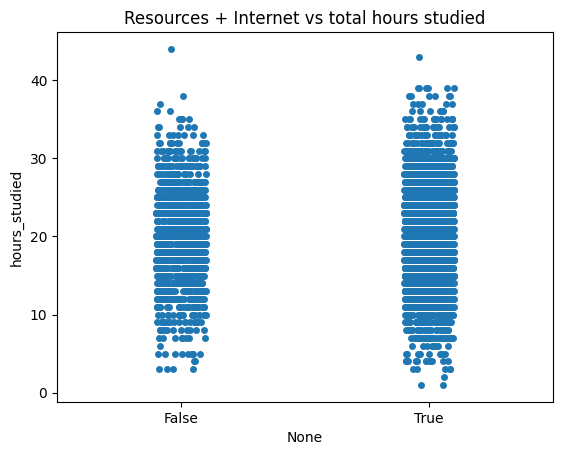

In [36]:
sns.stripplot(x=((df_full_train['access_to_resources'] != 'low') & (df_full_train['internet_access'] == 'yes')), y=df_full_train['hours_studied'])
plt.title('Resources + Internet vs total hours studied'); 

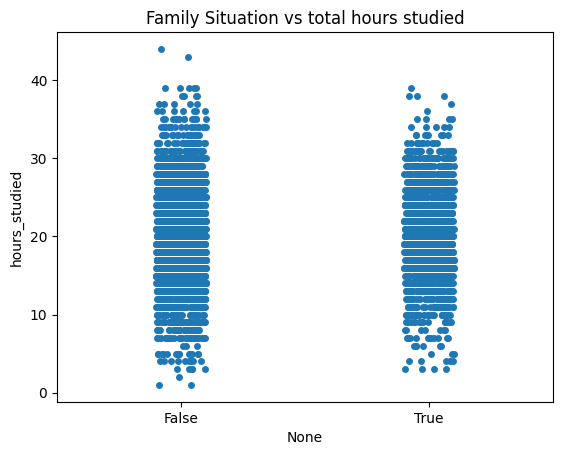

In [37]:
sns.stripplot(x=((df_full_train['family_income'] == 'low') & (df_full_train['parental_education_level'] != 'college')), y=df_full_train['hours_studied'])
plt.title('Family Situation vs total hours studied'); 

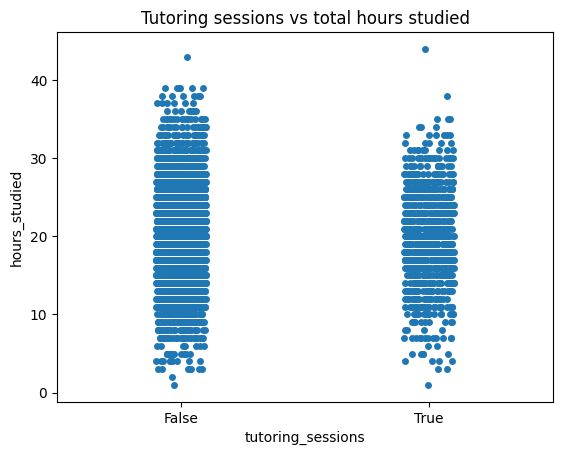

In [38]:
sns.stripplot(x=((df_full_train['tutoring_sessions'] >= 3)), y=df_full_train['hours_studied'])
plt.title('Tutoring sessions vs total hours studied'); 

Text(0.5, 0, 'Attendance x Exam score')

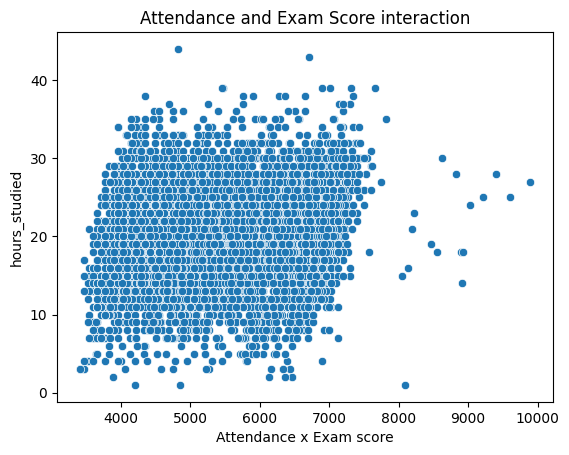

In [39]:
sns.scatterplot(x=df['attendance'] * df['exam_score'], y=df.hours_studied)
plt.title('Attendance and Exam Score interaction')
plt.xlabel('Attendance x Exam score')

This is quite similar to the plot of *exam_score*.

# Feature Engineering

In [40]:
# to_drop = ['gender', 'family_income', 'parental_education_level']
# df_full_train.drop(columns=to_drop, inplace=True)
# df_test.drop(columns=to_drop, inplace=True)

In [41]:
del df_full_train['hours_studied']
del df_test['hours_studied']
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full, test_size=len(df_test), random_state=1)

### One-hot encoding

In [42]:
dv = DictVectorizer(sparse=False)
# convert df to dictionary for dictvectorizer
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
# fit dv
dv.fit(train_dict)
# perform one hot encoding
X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

In [43]:
# train on validation
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

### Test Model for feature importance

In [44]:
# train the regression model with default parameters using xgb
params = {
    "eval_metric": "mae",              # mae for evaluation
    "learning_rate": 0.3,
    "max_depth": 6,
    "seed": 42
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dval, "Validation")],
    early_stopping_rounds=10,
    verbose_eval=10
)

[0]	Validation-mae:4.14931
[10]	Validation-mae:2.78820
[20]	Validation-mae:2.42488
[30]	Validation-mae:2.21828
[40]	Validation-mae:2.10829
[50]	Validation-mae:2.04396
[60]	Validation-mae:1.99952
[70]	Validation-mae:1.97899
[80]	Validation-mae:1.95776
[90]	Validation-mae:1.95246
[100]	Validation-mae:1.94549
[110]	Validation-mae:1.94602


In [45]:
feat_scores = dict(zip(dv.get_feature_names_out(), model.get_score(importance_type='weight').values()))
df_feat_scores = pd.DataFrame.from_dict(feat_scores, orient='index', columns=['Importance'])
df_feat_scores.sort_values(by='Importance', ascending=False)

,Importance
attendance,1128.0
peer_influence=negative,939.0
exam_score,811.0
school_type=public,369.0
peer_influence=positive,334.0
parental_involvement=medium,297.0
access_to_resources=high,158.0
extracurricular_activities=no,125.0
internet_access=no,110.0
access_to_resources=low,107.0


In [46]:
default_preds = model.predict(dval)
r2 = r2_score(y_val, default_preds)
print(f'R-squared(R²) Score: {r2}')

R-squared(R²) Score: 0.7446804046630859


### Checking for multicollinearity between attendance and exam score

In [47]:
train_no_exam_score = ['attendance', 'parental_involvement', 'access_to_resources',
       'extracurricular_activities', 'sleep_hours', 'previous_scores',
       'motivation_level', 'internet_access', 'tutoring_sessions',
       'family_income', 'teacher_quality', 'school_type', 'peer_influence',
       'physical_activity', 'learning_disabilities',
       'parental_education_level', 'distance_from_home', 'gender']

train_no_attendance = ['parental_involvement', 'access_to_resources',
       'extracurricular_activities', 'sleep_hours', 'previous_scores',
       'motivation_level', 'internet_access', 'tutoring_sessions',
       'family_income', 'teacher_quality', 'school_type', 'peer_influence',
       'physical_activity', 'learning_disabilities',
       'parental_education_level', 'distance_from_home', 'gender',
       'exam_score']

X_train_without_exam_score = df_train[train_no_exam_score].to_dict(orient='records')
X_train_without_attendance = df_train[train_no_attendance].to_dict(orient='records')
X_val_without_exam_score = df_val[train_no_exam_score].to_dict(orient='records')
X_val_without_attendance = df_val[train_no_attendance].to_dict(orient='records')
# without exam score
dv_wes = DictVectorizer(sparse=False)
# without attendance
dv_wea = DictVectorizer(sparse=False)

X_wes = dv_wes.fit_transform(X_train_without_exam_score)
X_val_wes = dv_wes.transform(X_val_without_exam_score)

X_wea = dv_wea.fit_transform(X_train_without_attendance)
X_val_wea = dv_wea.transform(X_val_without_attendance)

DX_wes = xgb.DMatrix(X_wes, label=y_train)
DX_val_wes = xgb.DMatrix(X_val_wes, label=y_val)

DX_wea = xgb.DMatrix(X_wea, label=y_train)
DX_val_wea = xgb.DMatrix(X_val_wea, label=y_val)

In [48]:
feat_scores = {}

In [49]:
params = {
    "eval_metric": "mae",              # mae for evaluation
    "learning_rate": 0.3,
    "max_depth": 6,
    "seed": 42
}

model = xgb.train(
    params,
    DX_wes, # train without exam_score
    num_boost_round=500,
    evals=[(DX_val_wes, "Validation")],
    early_stopping_rounds=10,
    verbose_eval=10
)

[0]	Validation-mae:4.73951
[10]	Validation-mae:4.85132
[11]	Validation-mae:4.88838


In [50]:
feat_scores["without_exam_scores"] = dict(zip(dv_wes.get_feature_names_out(), model.get_score(importance_type='weight').values()))
pd.DataFrame(feat_scores)

,without_exam_scores
access_to_resources=high,18.0
access_to_resources=low,12.0
access_to_resources=medium,9.0
attendance,144.0
distance_from_home=far,11.0
distance_from_home=moderate,10.0
distance_from_home=near,7.0
extracurricular_activities=no,16.0
extracurricular_activities=yes,12.0
family_income=high,7.0


In [51]:
params = {
    "eval_metric": "mae",              # mae for evaluation
    "learning_rate": 0.3,
    "max_depth": 6,
    "seed": 42
}

model = xgb.train(
    params,
    DX_wea, # train without exam_score
    num_boost_round=500,
    evals=[(DX_val_wea, "Validation")],
    early_stopping_rounds=10,
    verbose_eval=10
)

[0]	Validation-mae:4.39908
[10]	Validation-mae:4.03617
[18]	Validation-mae:4.07098


In [52]:
feat_scores["without_attendance"] = dict(zip(dv_wea.get_feature_names_out(), model.get_score(importance_type='weight').values()))

In [53]:
# display feature importance as dataframe
highlight_indices = ["attendance", "exam_score"]

def highlight_specific_rows(row):
    if row.name in highlight_indices:
        return ['background-color: lightblue'] * len(row)
    else:
        return [''] * len(row)

styled_df = pd.DataFrame(feat_scores).style.apply(highlight_specific_rows, axis=1)
styled_df

,without_exam_scores,without_attendance
access_to_resources=high,18.000000,24.000000
access_to_resources=low,12.000000,37.000000
access_to_resources=medium,9.000000,8.000000
attendance,144.000000,nan
distance_from_home=far,11.000000,23.000000
distance_from_home=moderate,10.000000,24.000000
distance_from_home=near,7.000000,19.000000
extracurricular_activities=no,16.000000,27.000000
extracurricular_activities=yes,12.000000,26.000000
family_income=high,7.000000,22.000000


Their(*attendance* and *exam_score*) importance when the other is not in the feature set becomes very bad compared to when both features are included. Additionally, the MAE is way better with both present. This suggests that they work better together when it comes to predicting the study_hours.

### Testing new feature/s

In [54]:
fdf_train = df_train.copy()
fdf_val = df_val.copy()
fdf_train['attendance_exam_interaction'] = df_train['attendance'] * df_train['exam_score']
fdf_val['attendance_exam_interaction'] = df_val['attendance'] * df_val['exam_score']

# remove the features that was combined
del fdf_train['attendance']
del fdf_train['exam_score']
del fdf_val['attendance']
del fdf_val['exam_score']

# convert to dictionary
feature_engineered_tdicts = fdf_train.to_dict(orient='records')
feature_engineered_vdicts = fdf_val.to_dict(orient='records')

# use new dictvectorizer
fe_dv = DictVectorizer(sparse=False)
fe_dv.fit(feature_engineered_tdicts)

# one hot encode
fX_train = fe_dv.transform(feature_engineered_tdicts)
fX_val = fe_dv.transform(feature_engineered_vdicts)

# convert to dmatrix
dfX_train = xgb.DMatrix(fX_train, label=y_train)
dfX_val = xgb.DMatrix(fX_val, label=y_val)

In [55]:
params = {
    "eval_metric": "mae",              # mae for evaluation
    "learning_rate": 0.3,
    "max_depth": 6,
    "seed": 42
}

model = xgb.train(
    params,
    dfX_train, # train without exam_score
    num_boost_round=500,
    evals=[(dfX_val, "Validation")],
    early_stopping_rounds=10,
    verbose_eval=10
)

[0]	Validation-mae:4.64961
[10]	Validation-mae:4.62594
[11]	Validation-mae:4.61672


In [56]:
feat_scores["combined"] = dict(zip(fe_dv.get_feature_names_out(), model.get_score(importance_type='weight').values()))
pd.DataFrame(feat_scores)

,without_exam_scores,without_attendance,combined
access_to_resources=high,18.0,24.0,26.0
access_to_resources=low,12.0,37.0,19.0
access_to_resources=medium,9.0,8.0,9.0
attendance,144.0,NaN,NaN
distance_from_home=far,11.0,23.0,10.0
distance_from_home=moderate,10.0,24.0,6.0
distance_from_home=near,7.0,19.0,7.0
extracurricular_activities=no,16.0,27.0,15.0
extracurricular_activities=yes,12.0,26.0,12.0
family_income=high,7.0,22.0,12.0


In [57]:
highlight_indices.append('attendance_exam_interaction')
styled_df = pd.DataFrame(feat_scores).style.apply(highlight_specific_rows, axis=1)
styled_df

,without_exam_scores,without_attendance,combined
access_to_resources=high,18.000000,24.000000,26.000000
access_to_resources=low,12.000000,37.000000,19.000000
access_to_resources=medium,9.000000,8.000000,9.000000
attendance,144.000000,nan,nan
distance_from_home=far,11.000000,23.000000,10.000000
distance_from_home=moderate,10.000000,24.000000,6.000000
distance_from_home=near,7.000000,19.000000,7.000000
extracurricular_activities=no,16.000000,27.000000,15.000000
extracurricular_activities=yes,12.000000,26.000000,12.000000
family_income=high,7.000000,22.000000,12.000000


Clearly, combining *attendance* and *exam_score* as one feature does not help the model to capture better patterns.

# Model

## Model Selection

#### XGBoost Model

In [58]:
# train the regression model with default params
params = {
    "eval_metric": "mae",              # mae for evaluation
    "learning_rate": 0.3,
    "max_depth": 6,
    "seed": 42
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=250,
    evals=[(dval, "Validation")],
    early_stopping_rounds=10,
    verbose_eval=10
)

[0]	Validation-mae:4.14931
[10]	Validation-mae:2.78820
[20]	Validation-mae:2.42488
[30]	Validation-mae:2.21828
[40]	Validation-mae:2.10829
[50]	Validation-mae:2.04396
[60]	Validation-mae:1.99952
[70]	Validation-mae:1.97899
[80]	Validation-mae:1.95776
[90]	Validation-mae:1.95246
[100]	Validation-mae:1.94549
[110]	Validation-mae:1.94602
[111]	Validation-mae:1.94613


#### Random Forest Regressor

In [69]:
rf_model = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
print(f'Random Forest MAE: {mean_absolute_error(y_val, rf_preds).round(5)}')

Random Forest MAE: 2.69212


I'd like to see the feature importance for the random forest model.

In [70]:
list(zip(dv.get_feature_names_out(), rf_model.feature_importances_.round(3)))

[('access_to_resources=high', np.float64(0.016)),
 ('access_to_resources=low', np.float64(0.02)),
 ('access_to_resources=medium', np.float64(0.005)),
 ('attendance', np.float64(0.219)),
 ('distance_from_home=far', np.float64(0.007)),
 ('distance_from_home=moderate', np.float64(0.005)),
 ('distance_from_home=near', np.float64(0.01)),
 ('exam_score', np.float64(0.336)),
 ('extracurricular_activities=no', np.float64(0.005)),
 ('extracurricular_activities=yes', np.float64(0.005)),
 ('family_income=high', np.float64(0.008)),
 ('family_income=low', np.float64(0.011)),
 ('family_income=medium', np.float64(0.005)),
 ('gender=female', np.float64(0.004)),
 ('gender=male', np.float64(0.004)),
 ('internet_access=no', np.float64(0.003)),
 ('internet_access=yes', np.float64(0.004)),
 ('learning_disabilities=no', np.float64(0.004)),
 ('learning_disabilities=yes', np.float64(0.005)),
 ('motivation_level=high', np.float64(0.01)),
 ('motivation_level=low', np.float64(0.008)),
 ('motivation_level=medium'

#### Decision Tree Regressor

In [71]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_val)
print(f'Decision Tree MAE: {mean_absolute_error(y_val, dt_preds).round(5)}')

Decision Tree MAE: 4.13793


In [72]:
list(zip(dv.get_feature_names_out(), dt_model.feature_importances_.round(3)))

[('access_to_resources=high', np.float64(0.017)),
 ('access_to_resources=low', np.float64(0.022)),
 ('access_to_resources=medium', np.float64(0.004)),
 ('attendance', np.float64(0.222)),
 ('distance_from_home=far', np.float64(0.007)),
 ('distance_from_home=moderate', np.float64(0.005)),
 ('distance_from_home=near', np.float64(0.01)),
 ('exam_score', np.float64(0.316)),
 ('extracurricular_activities=no', np.float64(0.006)),
 ('extracurricular_activities=yes', np.float64(0.005)),
 ('family_income=high', np.float64(0.009)),
 ('family_income=low', np.float64(0.013)),
 ('family_income=medium', np.float64(0.005)),
 ('gender=female', np.float64(0.006)),
 ('gender=male', np.float64(0.004)),
 ('internet_access=no', np.float64(0.007)),
 ('internet_access=yes', np.float64(0.002)),
 ('learning_disabilities=no', np.float64(0.004)),
 ('learning_disabilities=yes', np.float64(0.006)),
 ('motivation_level=high', np.float64(0.008)),
 ('motivation_level=low', np.float64(0.008)),
 ('motivation_level=mediu

There's a very big difference when it comes to the mean absolute error of each regressor model using the default parameters(with random state set to 42). **XGBoost** stands out with 1.94 error. **Random Forest Regressor** follows with 2.69 and finally, **Decision Tree Regressor** with 4.14 error. The similarity when it comes to feature importance can also be noticed with *exam_score* and *attendance* being the most significant contributor to each model.

### Tuning

In [73]:
# handling validation from xgb.train
def parse_output(output):
  df_score = []
  for line in output.split('\n')[:-1]: # separate each line
    # print(line)
    n_iter, validation_text = line.split('\t') # separate \t
    n_iter = int(n_iter.strip('[]')) # convert to integer after stripping the brackets
    result = float(validation_text.split(':')[1]) # extract the number
    df_score.append((n_iter, result))
  
  return pd.DataFrame(df_score, columns=["n_iteration", "mae"])

### XGBoost Tuning

In [74]:
xgb_scores = {} # for xgboost tuning

#### max_depth tuning

In [75]:
import io
from contextlib import redirect_stdout

# dictionary to store scores
xgb_scores = {}

for max_depth in np.linspace(1, 10, 10):  # 1 to 10
    # capture the console output
    output = io.StringIO()
    with redirect_stdout(output):
        params = {
            "eval_metric": "mae",  # mae for evaluation
            "learning_rate": 0.3,
            "max_depth": int(max_depth),
            "seed": 42
        }

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=500,
            evals=[(dval, "Validation")],
            early_stopping_rounds=10,
            verbose_eval=10
        )

    # retrieve captured output
    captured_output = output.getvalue()
    output.close()

    # parsing
    xgb_scores[f"max_depth={int(max_depth)}"] = parse_output(captured_output)

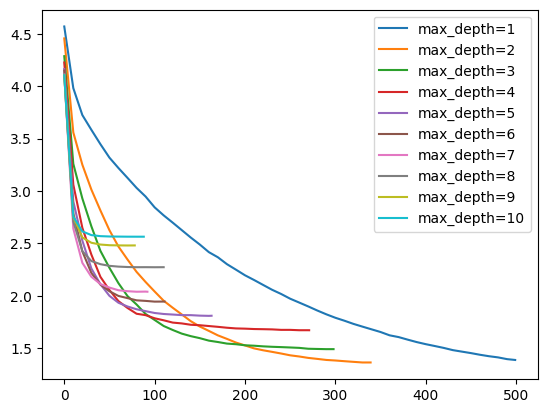

In [76]:
depths = np.linspace(1, 10, 10)
for d in depths:
    plt.plot(xgb_scores['max_depth=%s' % int(d)].n_iteration, 
             xgb_scores['max_depth=%s' % int(d)].mae,
            label=f"max_depth={int(d)}")
plt.legend()
plt.show()

**max_depth=2** does better than most. I can be sure that it wouldn't get any better because it can be noticed that the MAE only goes up the more I increase the depth.

In [77]:
max_depth = 2

#### learning_rate tuning

In [78]:
etas = np.linspace(0.01, 1.0, 20)

In [79]:
xgb_eta_scores = {}

for l in etas:  # 1 to 10
    # capture the console output
    output = io.StringIO()
    with redirect_stdout(output):
        params = {
            "eval_metric": "mae",  # mae for evaluation
            "learning_rate": l,
            "max_depth": max_depth,
            "seed": 42
        }

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=500,
            evals=[(dval, "Validation")],
            early_stopping_rounds=10,
            verbose_eval=10
        )

    # retrieve captured output
    captured_output = output.getvalue()
    output.close()

    # parsing
    xgb_eta_scores[f"eta={l}"] = parse_output(captured_output)

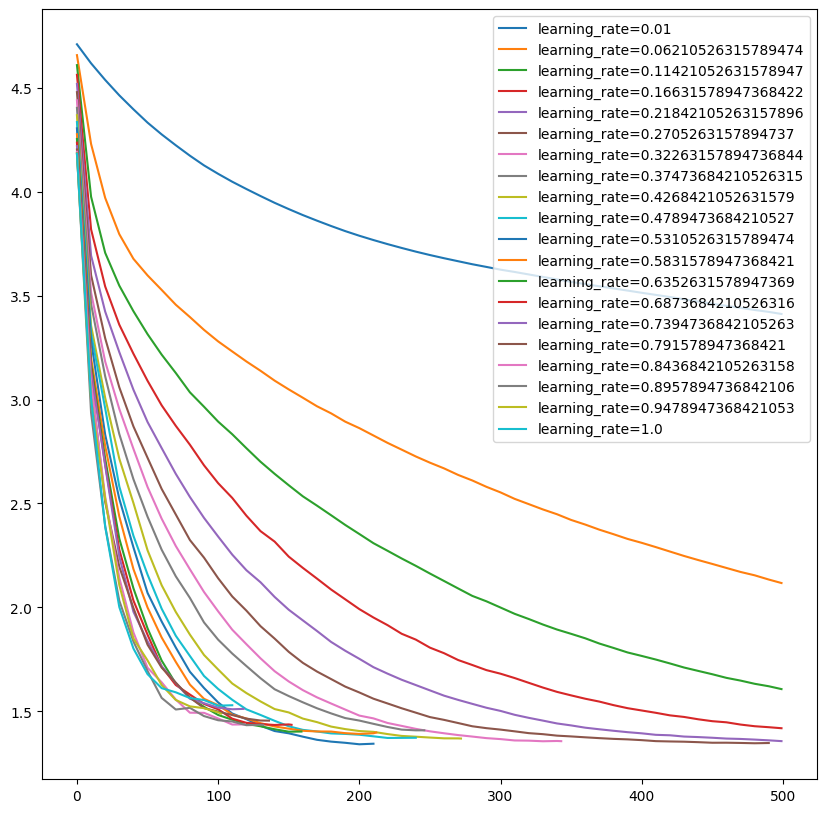

In [80]:
plt.figure(figsize=(10, 10))
for l in etas:
    plt.plot(xgb_eta_scores['eta=%s' % l].n_iteration, 
             xgb_eta_scores['eta=%s' % l].mae,
            label=f"learning_rate={l}")
plt.legend()
plt.show()

**learning_rate=0.53105263** appears to be an ideal option. I'd like to explore this more.

In [81]:
search_space = np.linspace(0.53105263 - .025, 0.53105263 + .025, 20)

In [82]:
xgb_eta_scores = {}

for l in search_space:  # 1 to 10
    # capture the console output
    output = io.StringIO()
    with redirect_stdout(output):
        params = {
            "eval_metric": "mae",  # mae for evaluation
            "learning_rate": l,
            "max_depth": max_depth,
            "seed": 42
        }

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=500,
            evals=[(dval, "Validation")],
            early_stopping_rounds=10,
            verbose_eval=10
        )

    # retrieve captured output
    captured_output = output.getvalue()
    output.close()

    # parsing
    xgb_eta_scores[f"eta={l}"] = parse_output(captured_output)

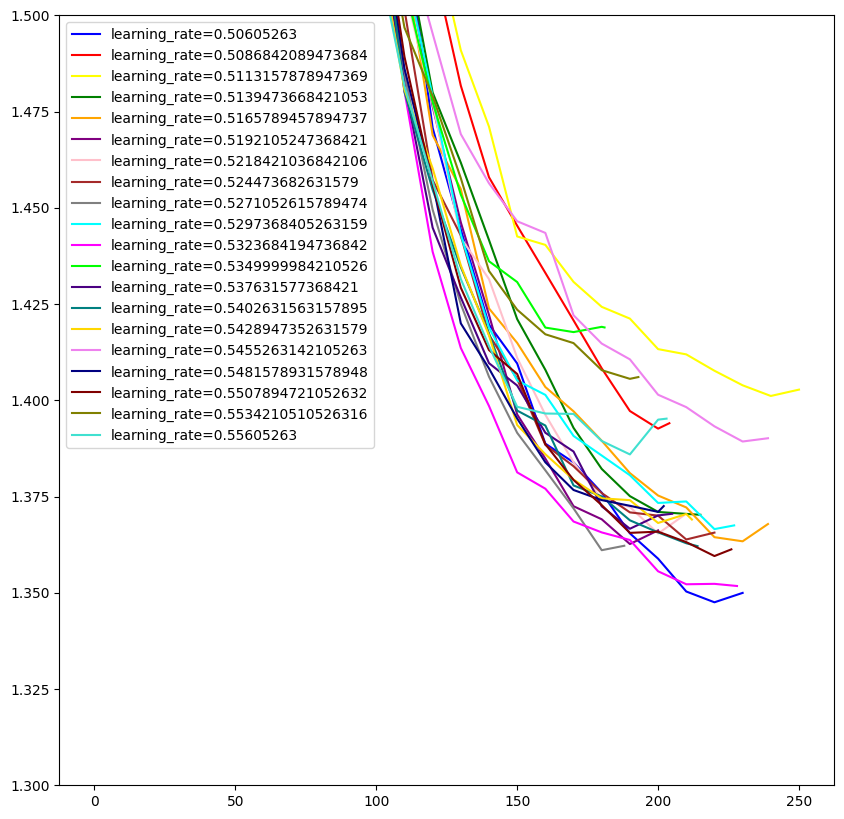

In [83]:
colors = ['blue', 'red', 'yellow', 'green', 'orange', 'purple', 'pink', 'brown', 'gray', 'cyan', 
 'magenta', 'lime', 'indigo', 'teal', 'gold', 'violet', 'navy', 'maroon', 'olive', 'turquoise']

plt.figure(figsize=(10, 10))

for i, l in enumerate(search_space):
    plt.plot(
        xgb_eta_scores['eta=%s' % l].n_iteration, 
        xgb_eta_scores['eta=%s' % l].mae,
        label=f"learning_rate={l}",
        color=colors[i % len(colors)]  # Cycle through colors if more lines than colors
    )

plt.legend()
plt.ylim(1.3, 1.5)
plt.show()

In [84]:
# i'm going with 0.50605263 eta
learning_rate = 0.50605263

#### min_child_weight tuning

In [85]:
xgb_min_child_weight_scores = {}

for mcw in np.linspace(1, 10, 10):  # 1 to 10
    # capture the console output
    output = io.StringIO()
    with redirect_stdout(output):
        params = {
            "eval_metric": "mae",  # mae for evaluation
            "learning_rate": learning_rate,
            "max_depth": max_depth,
            "min_child_weight": mcw,
            "seed": 42
        }

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=500,
            evals=[(dval, "Validation")],
            early_stopping_rounds=10,
            verbose_eval=10
        )

    # retrieve captured output
    captured_output = output.getvalue()
    output.close()

    # parsing
    xgb_min_child_weight_scores[f"min_child_weight={mcw}"] = parse_output(captured_output)

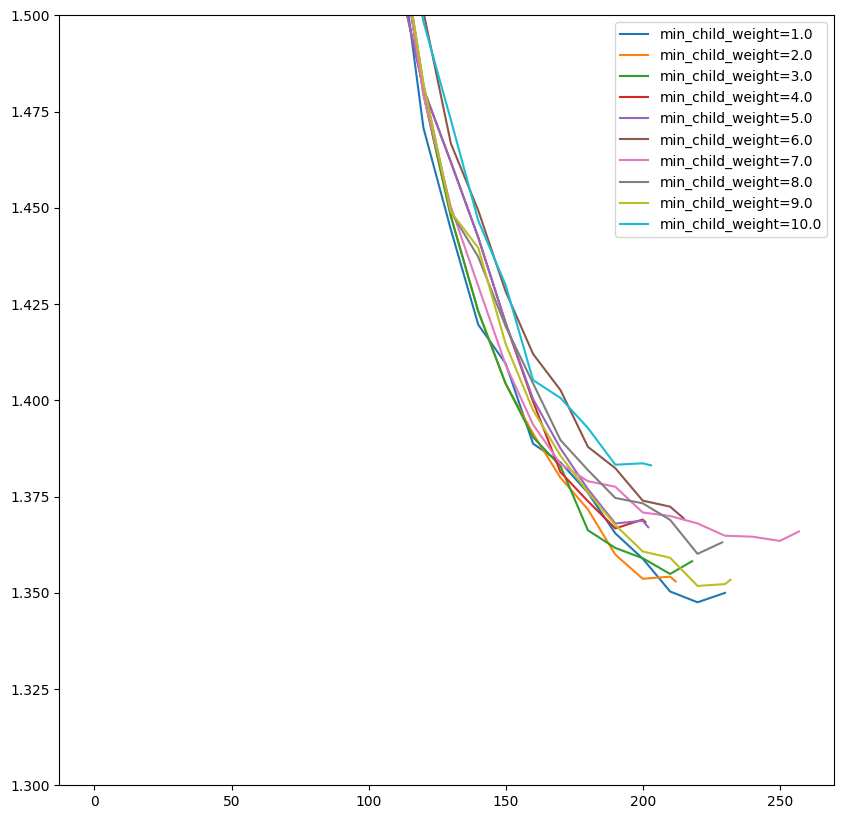

In [86]:
plt.figure(figsize=(10, 10))
for mcw in np.linspace(1, 10, 10):
    plt.plot(xgb_min_child_weight_scores[f"min_child_weight={mcw}"].n_iteration, 
             xgb_min_child_weight_scores[f"min_child_weight={mcw}"].mae,
            label=f"min_child_weight={mcw}")
plt.legend()
plt.ylim(1.3, 1.5)
plt.show()

Note that larger *min_child_weight* reduces overfitting. In this case, it seems that *min_child_weight* = 9 is as close as when it's 1.0.

In [87]:
min_child_weight = 9

#### colsample_bytree tuning

In [88]:
xgb_colsample_scores = {}

for sample in np.linspace(0.5, 1.0, 20):  # 1 to 10
    # capture the console output
    output = io.StringIO()
    with redirect_stdout(output):
        params = {
            "eval_metric": "mae",  # mae for evaluation
            "learning_rate": learning_rate,
            "max_depth": max_depth,
            "min_child_weight": mcw,
            "colsample_bytree": sample,
            "seed": 42
        }

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=500,
            evals=[(dval, "Validation")],
            early_stopping_rounds=10,
            verbose_eval=10
        )

    # retrieve captured output
    captured_output = output.getvalue()
    output.close()

    # parsing
    xgb_colsample_scores[f"xgb_colsample_scoressample={sample}"] = parse_output(captured_output)

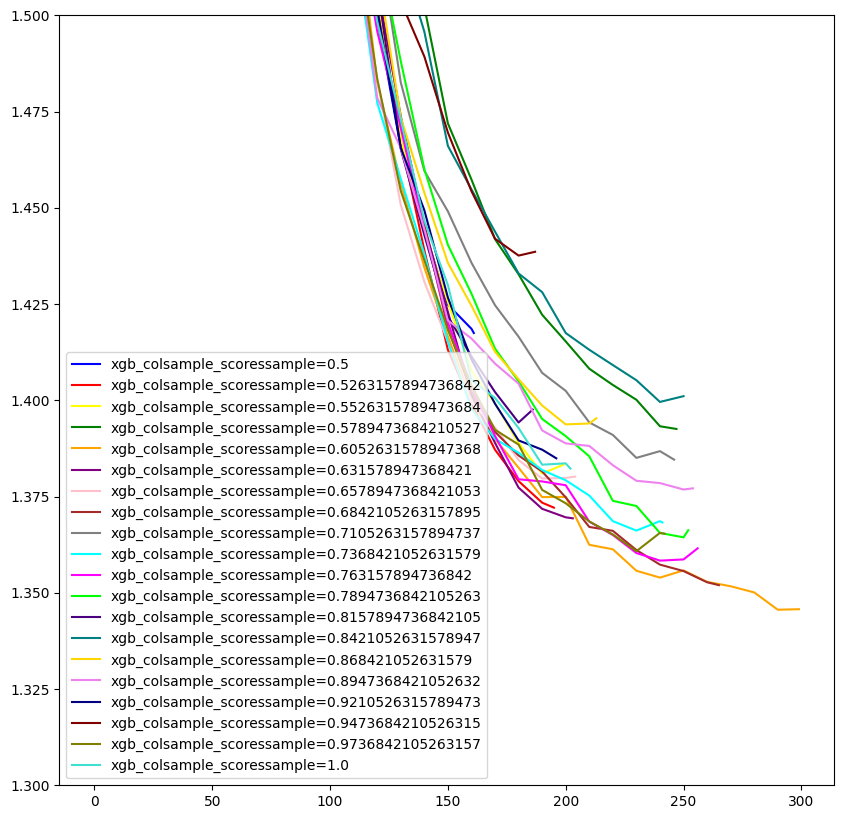

In [89]:
plt.figure(figsize=(10, 10))
for i, sample in enumerate(np.linspace(0.5, 1.0, 20)):
    plt.plot(
        xgb_colsample_scores[f"xgb_colsample_scoressample={sample}"].n_iteration, 
        xgb_colsample_scores[f"xgb_colsample_scoressample={sample}"].mae,
        label=f"xgb_colsample_scoressample={sample}",
        color=colors[i % len(colors)]  # Cycle through colors if more lines than colors
    )

plt.legend()
plt.ylim(1.3, 1.5)
plt.show()

In [90]:
colsample_bytree = 0.60526316

In [91]:
params = {
    "eval_metric": "mae",              # mae for evaluation
    "learning_rate": learning_rate,
    "max_depth": max_depth,
    "min_child_weight" : min_child_weight,
    "colsample_bytree": colsample_bytree,
    "seed": 42,
    "objective": 'reg:squarederror'
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dval, "Validation")],
    early_stopping_rounds=10,
    verbose_eval=10
)

[0]	Validation-mae:4.31883
[10]	Validation-mae:3.32435
[20]	Validation-mae:2.89855
[30]	Validation-mae:2.61065
[40]	Validation-mae:2.34683
[50]	Validation-mae:2.12201
[60]	Validation-mae:1.97579
[70]	Validation-mae:1.84757
[80]	Validation-mae:1.74810
[90]	Validation-mae:1.65297
[100]	Validation-mae:1.58351
[110]	Validation-mae:1.53432
[120]	Validation-mae:1.48449
[130]	Validation-mae:1.46672
[140]	Validation-mae:1.44595
[150]	Validation-mae:1.41844
[160]	Validation-mae:1.39457
[170]	Validation-mae:1.38085
[180]	Validation-mae:1.37177
[190]	Validation-mae:1.36895
[200]	Validation-mae:1.36157
[210]	Validation-mae:1.35764
[220]	Validation-mae:1.35358
[230]	Validation-mae:1.35699
[234]	Validation-mae:1.35403


In [92]:
learning_rate, max_depth, min_child_weight, colsample_bytree

(0.50605263, 2, 9, 0.60526316)

In [93]:
model_scores = {}
model_scores['xgb'] = (1.94613, 1.35403)

### Random Forest Regressor Tuning

#### n_estimators tuning

In [94]:
from tqdm import tqdm

rf_mae_scores = {}
estimators = np.linspace(100, 1000, 10)
for n_estimators in tqdm(estimators, desc="Processing"):
    current_score = []
    rf_model = RandomForestRegressor(n_estimators=int(n_estimators),
                                     n_jobs=-1,
                                     random_state=42)
    rf_model.fit(X_train, y_train)
    y_preds = rf_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_preds)
    current_score.append((n_estimators, mae))
    rf_mae_scores[f"n_estimators={int(n_estimators)}"] = pd.DataFrame(current_score, columns=['est', 'mae'])

Processing: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


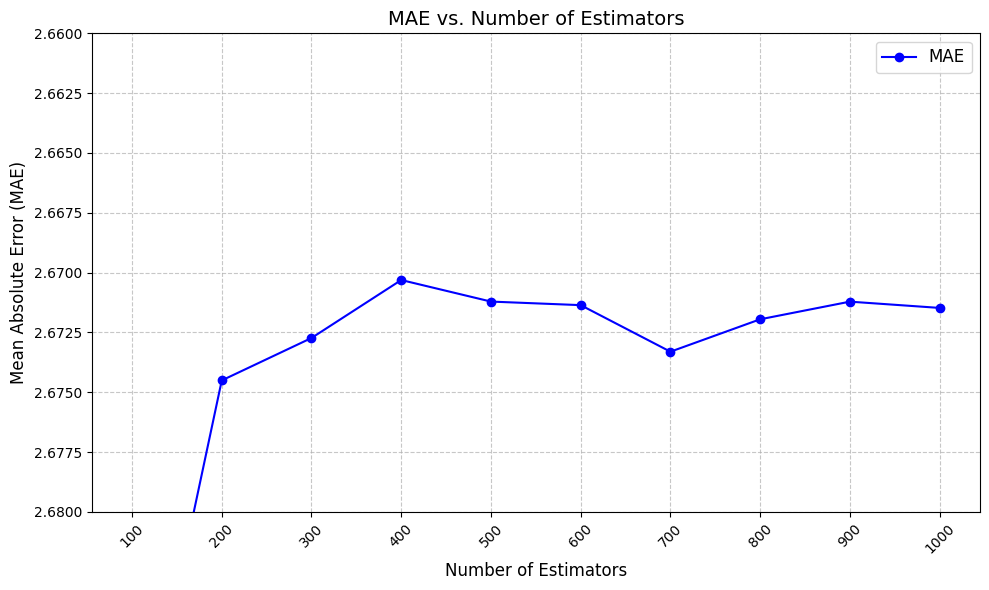

In [95]:
n_estimators_list = []
mae_list = []

for key, df in rf_mae_scores.items():
    n_estimators_list.append(df['est'].iloc[0])
    mae_list.append(df['mae'].iloc[0])

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, mae_list, marker='o', linestyle='-', color='b', label="MAE")
plt.title("MAE vs. Number of Estimators", fontsize=14)
plt.xlabel("Number of Estimators", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(n_estimators_list, rotation=45)
plt.ylim(2.68, 2.66)
plt.tight_layout()
plt.show()

n_estimators=400 seems like a good option but I'll try to search around that part for better results.

In [170]:
rf_mae_scores = {}
estimators = np.linspace(350, 500, 11)
for n_estimators in tqdm(estimators, desc="Processing"):
    current_score = []
    rf_model = RandomForestRegressor(n_estimators=int(n_estimators),
                                     n_jobs=-1,
                                     random_state=42)
    rf_model.fit(X_train, y_train)
    y_preds = rf_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_preds)
    current_score.append((n_estimators, mae))
    rf_mae_scores[f"n_estimators={int(n_estimators)}"] = pd.DataFrame(current_score, columns=['est', 'mae'])

Processing: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.13s/it]


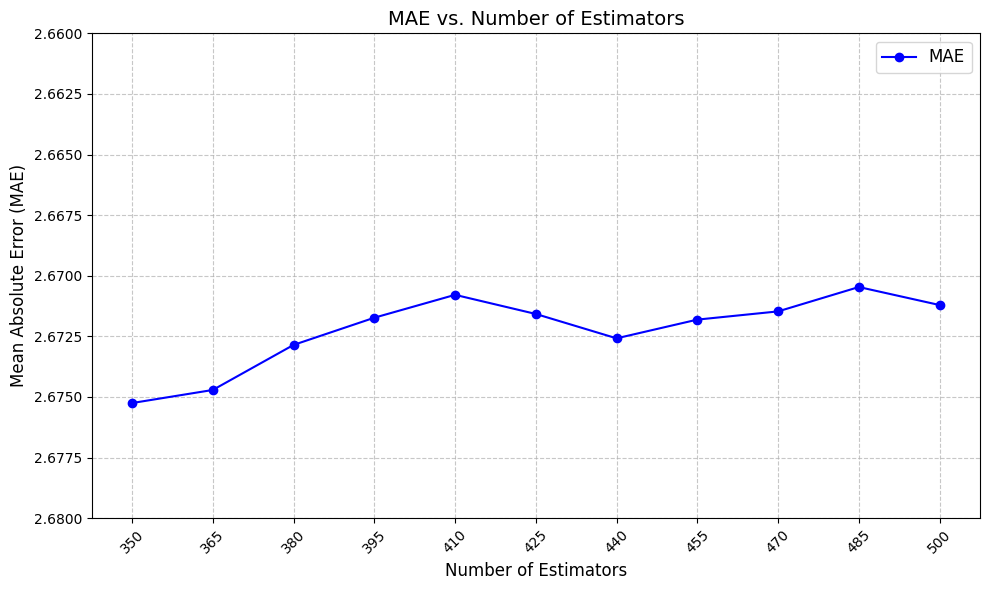

In [171]:
n_estimators_list = []
mae_list = []

for key, df in rf_mae_scores.items():
    n_estimators_list.append(df['est'].iloc[0])
    mae_list.append(df['mae'].iloc[0])

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, mae_list, marker='o', linestyle='-', color='b', label="MAE")
plt.title("MAE vs. Number of Estimators", fontsize=14)
plt.xlabel("Number of Estimators", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(n_estimators_list, rotation=45)
plt.ylim(2.68, 2.66)
plt.tight_layout()
plt.show()

Nothing much here. so I'll just do **n_estimators=400**

#### max_depth tuning

In [196]:
rf_mae_scores = {}
depths = np.linspace(2, 100, 50)
for d in tqdm(depths, desc="Processing"):
    current_score = []
    rf_model = RandomForestRegressor(n_estimators=400,
                                     max_depth=int(d),
                                     n_jobs=-1,
                                     random_state=42)
    rf_model.fit(X_train, y_train)
    y_preds = rf_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_preds)
    current_score.append((d, mae))
    rf_mae_scores[f"max_depth={int(d)}"] = pd.DataFrame(current_score, columns=['max_depth', 'mae'])

Processing: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


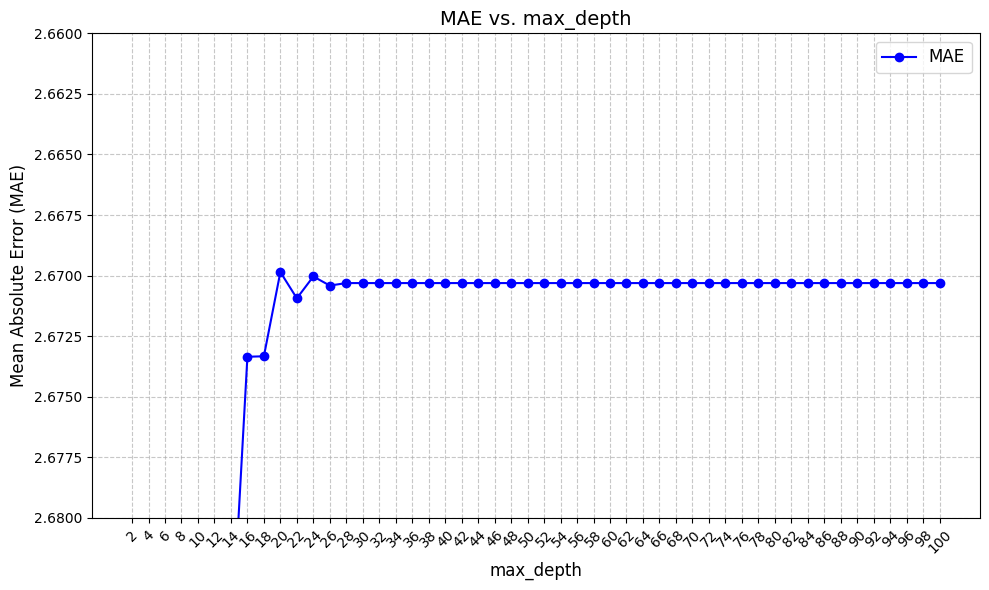

In [197]:
max_depth_list = []
mae_list = []

for key, df in rf_mae_scores.items():
    max_depth_list.append(df['max_depth'].iloc[0])
    mae_list.append(df['mae'].iloc[0])

plt.figure(figsize=(10, 6))
plt.plot(max_depth_list, mae_list, marker='o', linestyle='-', color='b', label="MAE")
plt.title("MAE vs. max_depth", fontsize=14)
plt.xlabel("max_depth", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(max_depth_list, rotation=45)
plt.ylim(2.68, 2.66)
plt.tight_layout()
plt.show()

**max_depth=18** appears to be a little bit better. The MAE stabilizes when max_depth>28

#### min_samples_split tuning

In [198]:
rf_mae_scores = {}
samples = np.linspace(2, 100, 50)
for s in tqdm(samples, desc="Processing"):
    current_score = []
    rf_model = RandomForestRegressor(n_estimators=400,
                                     max_depth=18,
                                     min_samples_split=int(s),
                                     n_jobs=-1,
                                     random_state=42)
    rf_model.fit(X_train, y_train)
    y_preds = rf_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_preds)
    current_score.append((s, mae))
    rf_mae_scores[f"min_samples_split={int(s)}"] = pd.DataFrame(current_score, columns=['min_samples_split', 'mae'])

Processing: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.87it/s]


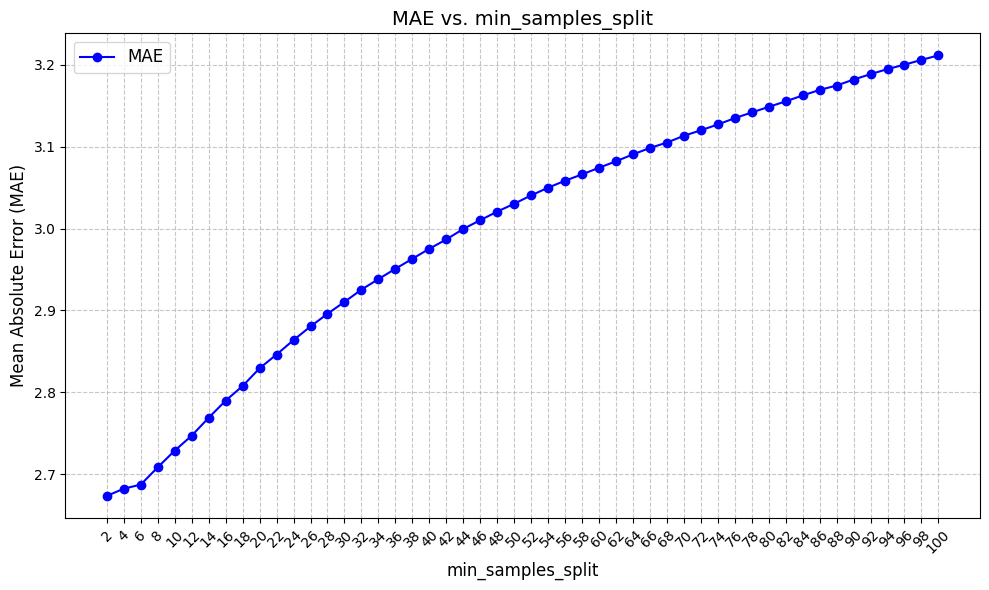

In [199]:
samples_list = []
mae_list = []

for key, df in rf_mae_scores.items():
    samples_list.append(df['min_samples_split'].iloc[0])
    mae_list.append(df['mae'].iloc[0])

plt.figure(figsize=(10, 6))
plt.plot(samples_list, mae_list, marker='o', linestyle='-', color='b', label="MAE")
plt.title("MAE vs. min_samples_split", fontsize=14)
plt.xlabel("min_samples_split", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(samples_list, rotation=45)
plt.tight_layout()
plt.show()

I can leave this paramater to *default*

#### min_samples_leaf tuning

In [200]:
rf_mae_scores = {}
leafs = np.linspace(2, 100, 50)
for l in tqdm(leafs, desc="Processing"):
    current_score = []
    rf_model = RandomForestRegressor(n_estimators=400,
                                     max_depth=18,
                                     min_samples_leaf=int(l),
                                     n_jobs=-1,
                                     random_state=42)
    rf_model.fit(X_train, y_train)
    y_preds = rf_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_preds)
    current_score.append((l, mae))
    rf_mae_scores[f"min_samples_leaf={int(l)}"] = pd.DataFrame(current_score, columns=['min_samples_leaf', 'mae'])

Processing: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.21it/s]


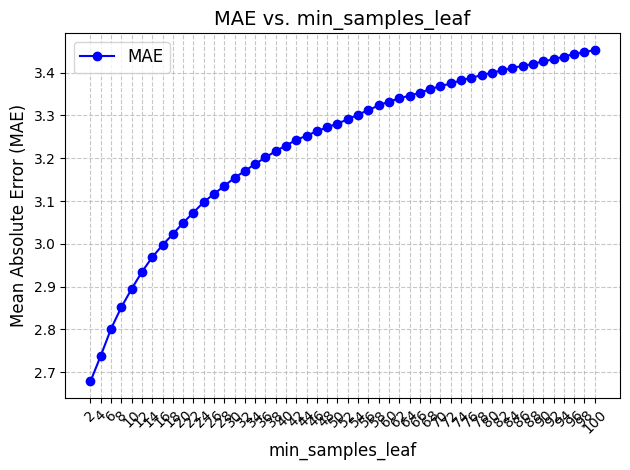

In [201]:
samples_leaf = []
mae_list = []

for key, df in rf_mae_scores.items():
    samples_leaf.append(df['min_samples_leaf'].iloc[0])
    mae_list.append(df['mae'].iloc[0])

plt.plot(samples_leaf, mae_list, marker='o', linestyle='-', color='b', label="MAE")
plt.title("MAE vs. min_samples_leaf", fontsize=14)
plt.xlabel("min_samples_leaf", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(samples_leaf, rotation=45)
plt.tight_layout()
plt.show()

It seems that the Random Forest Regressor model cannot get any better than the XGB model we fine tuned.

In [97]:
rf_model = RandomForestRegressor(n_estimators=400,
                                 max_depth=18,
                                 n_jobs=-1,
                                 random_state=42)
rf_model.fit(X_train, y_train)
y_preds = rf_model.predict(X_val)
mae = mean_absolute_error(y_val, y_preds)
mae

np.float64(2.6733292804983493)

In [98]:
model_scores['random_forest'] = (2.69212, 2.6733292804983493)

### Decision Tree Regressor

#### max_depth tuning

In [202]:
dt_mae_scores = {}
depths = np.linspace(2, 100, 50)
for d in tqdm(depths, desc="Processing"):
    current_score = []
    dt_model = DecisionTreeRegressor(max_depth=int(d), 
                                     random_state=42)
    dt_model.fit(X_train, y_train)
    y_preds = dt_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_preds)
    current_score.append((d, mae))
    dt_mae_scores[f"max_depth={int(d)}"] = pd.DataFrame(current_score, columns=['max_depth', 'mae'])

Processing: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.64it/s]


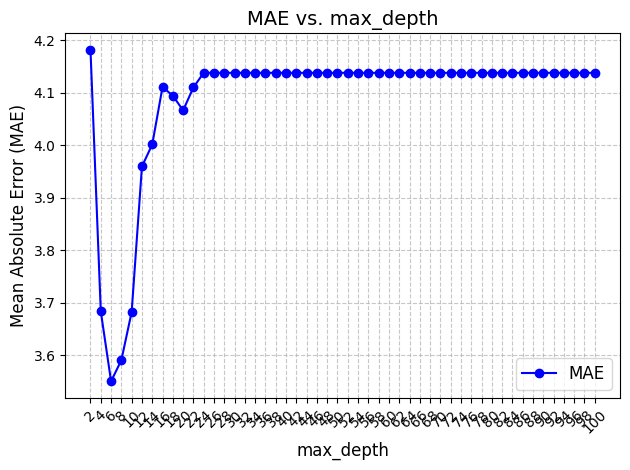

In [ ]:
max_depth = []
mae_list = []

for key, df in dt_mae_scores.items():
    max_depth.append(df['max_depth'].iloc[0])
    mae_list.append(df['mae'].iloc[0])

plt.plot(max_depth, mae_list, marker='o', linestyle='-', color='b', label="MAE")
plt.title("MAE vs. max_depth", fontsize=14)
plt.xlabel("max_depth", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(max_depth, rotation=45)
plt.tight_layout()
plt.show()

A significant spike in improvement can be seen from this graph. **max_depth=6** works best for this task.

#### min_samples_leaf tuning

In [211]:
dt_mae_scores = {}
min_samples_leaf = np.linspace(2, 100, 50)
for l in tqdm(min_samples_leaf, desc="Processing"):
    current_score = []
    dt_model = DecisionTreeRegressor(max_depth=6,
                                     min_samples_leaf=int(l),
                                     random_state=42)
    dt_model.fit(X_train, y_train)
    y_preds = dt_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_preds)
    current_score.append((l, mae))
    dt_mae_scores[f"min_split={int(l)}"] = pd.DataFrame(current_score, columns=['min_leaf', 'mae'])

Processing: 100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 128.75it/s]


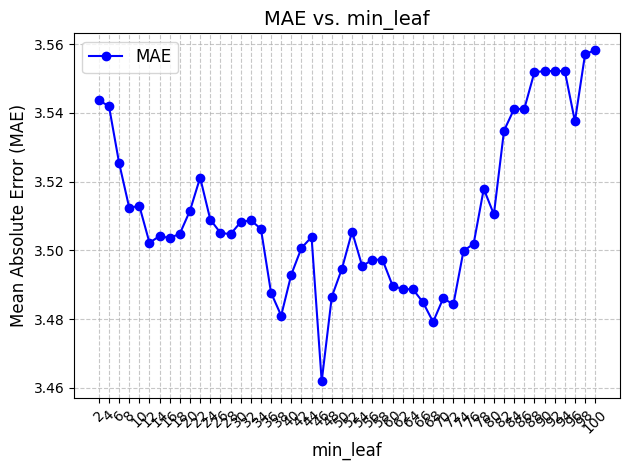

In [212]:
min_leaf = []
mae_list = []

for key, df in dt_mae_scores.items():
    min_leaf.append(df['min_leaf'].iloc[0])
    mae_list.append(df['mae'].iloc[0])

plt.plot(max_depth, mae_list, marker='o', linestyle='-', color='b', label="MAE")
plt.title("MAE vs. min_leaf", fontsize=14)
plt.xlabel("min_leaf", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(min_leaf, rotation=45)
plt.tight_layout()
plt.show()

**min_samples_leaf=46** is way better than other values.

#### min_samples_split tuning

In [213]:
dt_mae_scores = {}
min_samples_split = np.linspace(2, 100, 50)
for split in tqdm(min_samples_split, desc="Processing"):
    current_score = []
    dt_model = DecisionTreeRegressor(max_depth=6,
                                     min_samples_leaf=46,
                                     min_samples_split=int(split),
                                     random_state=42)
    dt_model.fit(X_train, y_train)
    y_preds = dt_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_preds)
    current_score.append((split, mae))
    dt_mae_scores[f"min_split={int(split)}"] = pd.DataFrame(current_score, columns=['split', 'mae'])

Processing: 100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 126.30it/s]


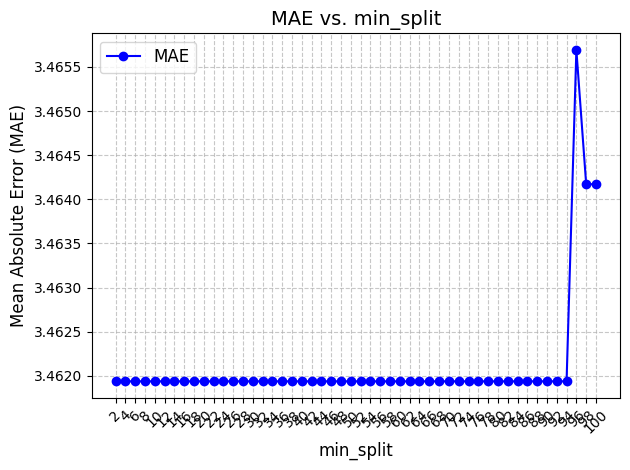

In [214]:
min_split = []
mae_list = []

for key, df in dt_mae_scores.items():
    min_split.append(df['split'].iloc[0])
    mae_list.append(df['mae'].iloc[0])

plt.plot(max_depth, mae_list, marker='o', linestyle='-', color='b', label="MAE")
plt.title("MAE vs. min_split", fontsize=14)
plt.xlabel("min_split", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(min_split, rotation=45)
plt.tight_layout()
plt.show()

Nothing I can do for this parameter.

#### max_leaf_nodes tuning

In [ ]:
dt_mae_scores = {}
max_nodes = np.linspace(5, 100, 20)
for n in tqdm(max_nodes, desc="Processing"):
    current_score = []
    dt_model = DecisionTreeRegressor(max_depth=6,
                                     min_samples_leaf=46,
                                     max_leaf_nodes=int(n),
                                     random_state=42)
    dt_model.fit(X_train, y_train)
    y_preds = dt_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_preds)
    current_score.append((n, mae))
    dt_mae_scores[f"max_nodes={int(n)}"] = pd.DataFrame(current_score, columns=['nodes', 'mae'])

Processing: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.17it/s]


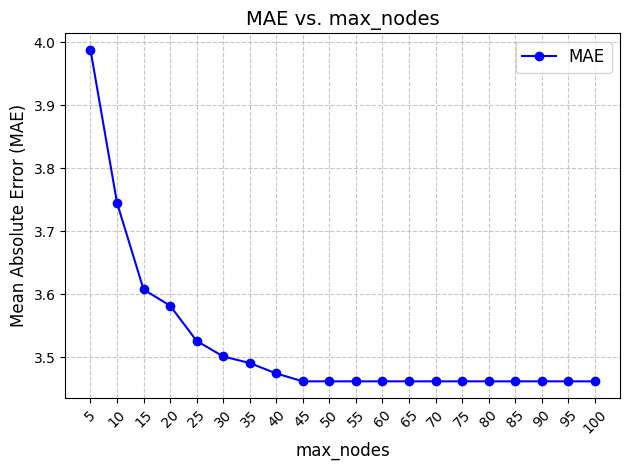

In [222]:
nodes = []
mae_list = []

for key, df in dt_mae_scores.items():
    nodes.append(df['nodes'].iloc[0])
    mae_list.append(df['mae'].iloc[0])

plt.plot(nodes, mae_list, marker='o', linestyle='-', color='b', label="MAE")
plt.title("MAE vs. max_nodes", fontsize=14)
plt.xlabel("max_nodes", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(nodes, rotation=45)
plt.tight_layout()
plt.show()

**max_leaf_nodes=45** is where the trend stabilizes.

In [96]:
dt_model = DecisionTreeRegressor(max_depth=6,
                                 min_samples_leaf=46,
                                 max_leaf_nodes=45,
                                 random_state=42)
dt_model.fit(X_train, y_train)
y_preds = dt_model.predict(X_val)
mae = mean_absolute_error(y_val, y_preds)
mae

np.float64(3.4619364971633235)

In [99]:
model_scores['decision_tree'] = (4.13793, 3.4619364971633235)

### Scores Review

In [100]:
df_model_scores = pd.DataFrame(model_scores, index=["default_parameters", "tuned_parameters"]).T

In [101]:
df_model_scores

,default_parameters,tuned_parameters
xgb,1.94613,1.354030
random_forest,2.69212,2.673329
decision_tree,4.13793,3.461936


The **xgb model** is the best among the three. Random Forest comes second but didn't improve much after tuning. Decision Tree significantly improved but is still not good enough.

### Full Training

In [102]:
test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

full_dict = df_full_train.to_dict(orient='records')
X_full = dv.transform(full_dict)

# train on full
dtrain = xgb.DMatrix(X_full, label=y_full)
dval = xgb.DMatrix(X_test, label=y_test)

params = {
    "eval_metric": "mae",            
    "learning_rate": 0.50605263,
    "max_depth": 2,
    "min_child_weight": 9,
    "colsample_bytree": 0.60526316,
    "objective": "reg:squarederror",
    "seed": 42
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dval, "Validation")],
    early_stopping_rounds=10,
    verbose_eval=10
)

# predict
y_pred = model.predict(xgb.DMatrix(X_test))
# assign each prediction to the closest ordinal category
y_pred_cat = np.round(y_pred).astype(int)

# mae
mae = mean_absolute_error(y_test, y_pred)
print("Final Mean Absolute Error:", mae)

[0]	Validation-mae:4.32028
[10]	Validation-mae:3.35408
[20]	Validation-mae:2.90302
[30]	Validation-mae:2.58250
[40]	Validation-mae:2.30596
[50]	Validation-mae:2.11198
[60]	Validation-mae:1.94446
[70]	Validation-mae:1.80624
[80]	Validation-mae:1.70449
[90]	Validation-mae:1.64021
[100]	Validation-mae:1.56392
[110]	Validation-mae:1.50874
[120]	Validation-mae:1.46608
[130]	Validation-mae:1.43634
[140]	Validation-mae:1.41207
[150]	Validation-mae:1.39629
[160]	Validation-mae:1.36977
[170]	Validation-mae:1.35656
[180]	Validation-mae:1.34734
[185]	Validation-mae:1.34649
Final Mean Absolute Error: 1.3496400269221362


In [103]:
# for categorizing the target variable 'hours_studied'
def categorize_hours(hours):
    middle = np.round(hours)
    return (middle-2, middle+2)

predicted_cat = pd.Series(y_pred_cat).apply(categorize_hours)
actual_cat = pd.Series(y_test)
df_result = pd.DataFrame({
    'predictions': y_pred,
    'actual': y_test,
    'predicted_cat': predicted_cat,
    'actual_cat': actual_cat
})
r2 = r2_score(y_test, y_pred)
print(f'R-squared(R²) Score: {r2}')

R-squared(R²) Score: 0.7857850193977356


I decided to make the range of estimation +-2. This would allow for more flexibility when it comes to time management as many other factors may affect the number of hours a student needs for studying. 

In [104]:
# function to check if an actual category falls within a predicted category
def is_within_range(actual, predicted):
    return predicted[0] <= actual <= predicted[1]

# calculate the accuracy
accuracy = df_result.apply(lambda row: is_within_range(row['actual_cat'], row['predicted_cat']), axis=1).mean()
print(f'Accuracy: {accuracy}')

Accuracy: 0.9028213166144201


### Test on random Sample

Random Sample: 
```
{'hours_studied': 27,
 'attendance': 68,
 'parental_involvement': 'medium',
 'access_to_resources': 'medium',
 'extracurricular_activities': 'yes',
 'sleep_hours': 7,
 'previous_scores': 95,
 'motivation_level': 'low',
 'internet_access': 'yes',
 'tutoring_sessions': 0,
 'family_income': 'medium',
 'teacher_quality': 'medium',
 'school_type': 'public',
 'peer_influence': 'positive',
 'physical_activity': 4,
 'learning_disabilities': 'no',
 'parental_education_level': 'high_school',
 'distance_from_home': 'near',
 'gender': 'male',
 'exam_score': 67}
```

In [142]:
test_student = {'attendance': 68,
 'parental_involvement': 'medium',
 'access_to_resources': 'medium',
 'extracurricular_activities': 'yes',
 'sleep_hours': 7,
 'previous_scores': 95,
 'motivation_level': 'low',
 'internet_access': 'yes',
 'tutoring_sessions': 0,
 'family_income': 'medium',
 'teacher_quality': 'medium',
 'school_type': 'public',
 'peer_influence': 'positive',
 'physical_activity': 4,
 'learning_disabilities': 'no',
 'parental_education_level': 'high_school',
 'distance_from_home': 'near',
 'gender': 'male',
 'exam_score': 67}

student = dv.transform(test_student)
pd.Series(model.predict(xgb.DMatrix(student)))

0    25.135786
dtype: float32

# Save Model

In [143]:
output_file=f'study_hestimator.bin'

# f_out = open(output_file, 'wb')
with open(output_file, 'wb') as f_out:
    pickle.dump((model, dv), f_out)

# Loading Test

In [107]:
import pickle

model_file=f'study_hestimator.bin'

with open(model_file, 'rb') as f_in:
    model, dv = pickle.load(f_in)

model, dv

(<xgboost.core.Booster at 0x203f8beb920>, DictVectorizer(sparse=False))

In [110]:
import xgboost as xgb
test_student = {'attendance': 68,
 'parental_involvement': 'medium',
 'access_to_resources': 'medium',
 'extracurricular_activities': 'yes',
 'sleep_hours': 7,
 'previous_scores': 95,
 'motivation_level': 'low',
 'internet_access': 'yes',
 'tutoring_sessions': 0,
 'family_income': 'medium',
 'teacher_quality': 'medium',
 'school_type': 'public',
 'peer_influence': 'positive',
 'physical_activity': 4,
 'learning_disabilities': 'no',
 'parental_education_level': 'high_school',
 'distance_from_home': 'near',
 'gender': 'male',
 'exam_score': 67}

student = dv.transform(test_student)
model.predict(xgb.DMatrix(student))

array([25.135786], dtype=float32)

I've confirmed that it is working.